In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

In [3]:
def make_df(fnames, 
    old_frame=None, 
    reward_ahead=10, 
    timestep_gap=1, 
    prev_act_window=3, 
    jump_limit=100,
    ):

    '''
    Takes a file and turns it into a trajectory dataframe.
    Can add to old data.
    Inputs:
                old_frame: old df
             reward_ahead: how many steps ahead to sum reward, for each table entry
             timestep_gap: how data are sampled (e.g. =5 means only every fifth datapoint is kept)
          prev_act_window: how many steps to look back to make sure all actions were 'on' or 'off'
               jump_limit: data are processed to remove faulty points where worm loc has jumped really far.
                           This is the maximum jump distance allowed before points are tossed.
                     disc: discretization of angles

    Output:
        dataframe object with keys:
            't', 'obs_b', 'obs_h', 'prev_actions', 'next_obs_b', 'next_obs_h', 'reward', 'loc'
    '''
    def add_ind_to_df(traj,df,i, reward_ahead, prev_act_window):
        # Assumes data for angle observations go from -1 to 1. (not sure why)
        ANG_BOUND = 180
        return df.append({
            't'           : traj['t'][i],
            'obs_b'       : int(traj['obs'][i][0]*ANG_BOUND),
            'obs_h'       : int(traj['obs'][i][1]*ANG_BOUND),
            'prev_actions': sum(traj['action'][i-prev_act_window:i]), # Note does not include current action
            'next_obs_b'  : int(traj['obs'][i+1][0]*ANG_BOUND),
            'next_obs_h'  : int(traj['obs'][i+1][1]*ANG_BOUND),
            'reward'      : sum(traj['reward'][i:i+reward_ahead]),
            'loc'         : traj['loc'][i],
        }, ignore_index=True)

    if old_frame is None:
        df = pd.DataFrame(columns = ['t', 
            'obs_b', 'obs_h', 'prev_actions', 
            'next_obs_b', 'next_obs_h', 'reward', 'loc'])
    else:
        df = old_frame

    # For every file, loop through and remove problem points.
    for fname in fnames:
        newf = True
        with open(fname, 'rb') as f:
            traj = pickle.load(f)

        for i in np.arange(prev_act_window,len(traj['t'])-reward_ahead,timestep_gap):
            # For every timestep, check if the jump is reasonable and add to dataframe.
            if newf:
                if sum(traj['loc'][i])!=0:
                    df = add_ind_to_df(traj,df,i,reward_ahead,prev_act_window)
                    newf = False
            elif np.sqrt(np.sum(np.square(df['loc'].iloc[-1]-traj['loc'][i]))) < jump_limit:
                df = add_ind_to_df(traj,df,i,reward_ahead,prev_act_window)

    return df

In [81]:
fnames=[
    # First worm
     'Data/traj12-11-2020_19-04-41.pkl', #none
     'Data/traj12-11-2020_19-14-38.pkl', #none
#     'Data/traj12-11-2020_19-24-30.pkl', #xlim 800
#     'Data/traj12-11-2020_19-35-31.pkl', #none # Seems like an especially bad dataset. Actually ruined all the others

#     # Second worm
#     'Data/traj12-11-2020_19-55-19.pkl', #none
#     'Data/traj12-11-2020_20-05-11.pkl', #none
#     'Data/traj12-11-2020_20-15-17.pkl', #none
#     'Data/traj12-11-2020_20-25-06.pkl', #xlim 1430

#     # Third worm
#     'Data/traj30-10-2020_18-14-00.pkl', #none
#     'Data/traj30-10-2020_18-34-10.pkl', #none

#     # Fourth worm
#     'Data/traj02-11-2020_15-53-56.pkl', #none 
#     'Data/traj02-11-2020_16-14-45.pkl', #none 

#     # Fifth worm
#     'Data/traj03-11-2020_14-46-45.pkl', #none
#     'Data/traj03-11-2020_15-08-07.pkl', #none
]

traj_df = make_df(fnames, 
    old_frame=None, 
    reward_ahead=10, 
    timestep_gap=5, 
    prev_act_window=3, 
    jump_limit=100,
    )

In [78]:
#traj_df.to_pickle('./all_traj_df.pkl')

In [36]:
traj_df

,t,obs_b,obs_h,prev_actions,next_obs_b,next_obs_h,reward,loc
0,0.953,30,60,3,-150,-120,-3.616162,"[848.7272727272727, 1067.8181818181818]"
1,1.859,150,150,0,-150,-120,-0.602273,"[848.0, 1068.3333333333333]"
2,2.812,150,-60,0,150,150,0.674603,"[847.3333333333334, 1068.5555555555557]"
3,3.734,-30,-60,0,-30,-60,-0.701299,"[846.2727272727273, 1069.7272727272727]"
4,4.687,-30,90,0,-30,90,-2.369048,"[845.75, 1070.0]"
...,...,...,...,...,...,...,...,...
991,87.000,30,0,3,30,0,4.060478,"[507.08333333333337, 874.9583333333334]"
992,87.890,30,-30,3,30,-30,1.979365,"[504.8955223880597, 870.6417910447761]"
993,88.844,30,0,3,30,0,1.673480,"[504.93220338983053, 870.7966101694915]"
994,89.734,30,-30,3,30,-30,3.643290,"[504.50666666666666, 868.88]"


In [70]:
locs = np.zeros((len(traj_df),2))
for i in range(locs.shape[0]):
    locs[i,:] = traj_df['loc'][i]

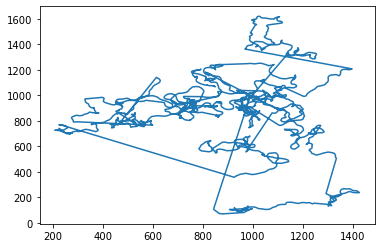

In [82]:
plt.plot(locs[:,0],locs[:,1])

In [79]:
traj_df

,t,obs_b,obs_h,prev_actions,next_obs_b,next_obs_h,reward,loc
0,0.953,30,60,3,-150,-120,-3.616162,"[848.7272727272727, 1067.8181818181818]"
1,1.859,150,150,0,-150,-120,-0.602273,"[848.0, 1068.3333333333333]"
2,2.812,150,-60,0,150,150,0.674603,"[847.3333333333334, 1068.5555555555557]"
3,3.734,-30,-60,0,-30,-60,-0.701299,"[846.2727272727273, 1069.7272727272727]"
4,4.687,-30,90,0,-30,90,-2.369048,"[845.75, 1070.0]"
...,...,...,...,...,...,...,...,...
991,87.000,30,0,3,30,0,4.060478,"[507.08333333333337, 874.9583333333334]"
992,87.890,30,-30,3,30,-30,1.979365,"[504.8955223880597, 870.6417910447761]"
993,88.844,30,0,3,30,0,1.673480,"[504.93220338983053, 870.7966101694915]"
994,89.734,30,-30,3,30,-30,3.643290,"[504.50666666666666, 868.88]"


In [99]:
obs = [30,60]
df = traj_df
cut_reversals = True

if cut_reversals:
    backwards = obs[0]-180
    if backwards < -180:
        backwards += 360
else:
    backwards = 1e4

df_d = dict(zip(df.columns,range(len(df.columns))))
series = df.query('obs_b=='+str(obs[0])+'& obs_h=='+str(obs[1])+
    '& next_obs_b!='+str(backwards)).copy()
series.iloc[:,df_d['next_obs_b']] = wrap_correct(series['next_obs_b'].to_numpy(),ref=series['obs_b'].to_numpy())
series.iloc[:,df_d['next_obs_h']] = wrap_correct(series['next_obs_h'].to_numpy(),ref=series['obs_h'].to_numpy())


In [108]:
def wrap_correct(arr,ref=0,buffer=180):
    # Takes angles and translates them to +/-buffer around ref.
    # For things like std, use large buffer so it doesn't change
    # If both arrays, send each element through this function.
    if hasattr(arr,"__len__"):
        if hasattr(ref,"__len__"):
            for i in range(len(arr)):
                arr[i] = wrap_correct(arr[i],ref=ref[i])
        # If only arr is an array
        else:
            arr[arr<ref-buffer]+=buffer*2
            arr[arr>=ref+buffer]-=buffer*2
            if len(arr[arr<ref-buffer])>0 or len(arr[arr>=ref+buffer])>0:
                arr = wrap_correct(arr,ref=ref)
    else:
        if arr<ref-buffer:
            arr+=buffer*2
            if arr<ref-buffer:
                arr = wrap_correct(arr,ref=ref)
        elif arr>=ref+buffer:
            arr-=buffer*2
            if arr>=ref+buffer:
                arr = wrap_correct(arr,ref=ref)
    return arr

In [112]:
traj_df

,t,obs_b,obs_h,prev_actions,next_obs_b,next_obs_h,reward,loc
0,0.953,30,60,3,-150,-120,-3.616162,"[848.7272727272727, 1067.8181818181818]"
1,1.859,150,150,0,-150,-120,-0.602273,"[848.0, 1068.3333333333333]"
2,2.812,150,-60,0,150,150,0.674603,"[847.3333333333334, 1068.5555555555557]"
3,3.734,-30,-60,0,-30,-60,-0.701299,"[846.2727272727273, 1069.7272727272727]"
4,4.687,-30,90,0,-30,90,-2.369048,"[845.75, 1070.0]"
...,...,...,...,...,...,...,...,...
991,87.000,30,0,3,30,0,4.060478,"[507.08333333333337, 874.9583333333334]"
992,87.890,30,-30,3,30,-30,1.979365,"[504.8955223880597, 870.6417910447761]"
993,88.844,30,0,3,30,0,1.673480,"[504.93220338983053, 870.7966101694915]"
994,89.734,30,-30,3,30,-30,3.643290,"[504.50666666666666, 868.88]"


In [45]:
dict(zip(series.columns,range(len(series.columns))))

{'t': 0,
 'obs_b': 1,
 'obs_h': 2,
 'prev_actions': 3,
 'next_obs_b': 4,
 'next_obs_h': 5,
 'reward': 6,
 'loc': 7}

In [129]:
def make_stat_mats(df, cut_reversals=True):
    # This version should have an option to check HT switches so I can test.
    # Inner func does most of the work querying for each obs.
    # cut_reversals is True if body angle switches happen. Note that it does cut both incorrect
    #   switches and correct ones.
    # Returns everything at once: 
    #   r_mat[12,12,2], b_mat[12,12,2], h_mat[12,12,2], counts[12,12].

    def get_stats_angs(df, obs, cut_reversals=True):
        # Gets mean and var of df values that match obs, centered on obs
        # Remove points where HT orientation switched
        # Returns r_stats, b_stats, h_stats, count. The first three are tuples [mu,var].

        if cut_reversals:
            backwards = obs[0]-180
            if backwards < -180:
                backwards += 360
        else:
            backwards = 1e5

        df_d = dict(zip(df.columns,range(len(df.columns))))
        series = df.query('obs_b=='+str(obs[0])+'& obs_h=='+str(obs[1])+
            '& next_obs_b!='+str(backwards)).copy()
        series.iloc[:,df_d['next_obs_b']] = wrap_correct(series['next_obs_b'].to_numpy(),ref=series['obs_b'].to_numpy())
        series.iloc[:,df_d['next_obs_h']] = wrap_correct(series['next_obs_h'].to_numpy(),ref=series['obs_h'].to_numpy())

        # Handles case for one sample (initialize)
        r_sts,b_sts,h_sts,count = [np.nan,np.nan],[np.nan,np.nan],[np.nan,np.nan],0
        if series.size > 0:    
            r_sts[0],b_sts[0],h_sts[0] = wrap_correct(series['reward'].mean()), \
                                            wrap_correct(series['next_obs_b'].mean()), \
                                            wrap_correct(series['next_obs_h'].mean())
            if series.size > 1:
                r_sts[1],b_sts[1],h_sts[1] = series['reward'].var(), \
                                                series['next_obs_b'].var(), \
                                                series['next_obs_h'].var()
        return r_sts,b_sts,h_sts,series.size


    r_mat = np.zeros((12,12,2)) + np.nan 
    b_mat = np.zeros((12,12,2)) + np.nan 
    h_mat = np.zeros((12,12,2)) + np.nan 
    counts = np.zeros((12,12))

    for i,theta_b in enumerate(np.arange(-180,180,30)):
        for j,theta_h in enumerate(np.arange(-180,180,30)):
            r_sts,b_sts,h_sts,counts[i,j] = get_stats_angs(df,[theta_b,theta_h])
            r_mat[i,j,:] = r_sts
            b_mat[i,j,:] = b_sts
            h_mat[i,j,:] = h_sts

    return r_mat, b_mat, h_mat, counts

In [130]:
r_mat, b_mat, h_mat, counts = make_stat_mats(traj_df)

# THINGS TO EDIT: ONE VARIANCE IS TOO BIG CAUSE WRAP_CORRECT ISN'T WORKING RIGHT. FIX THAT

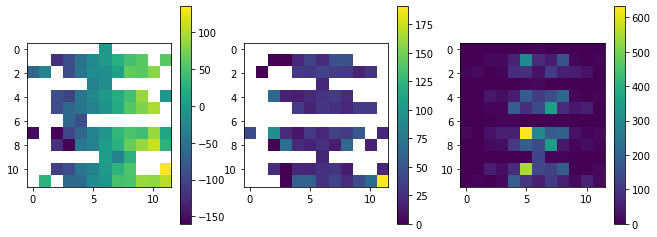

In [137]:
fig,ax = plt.subplots(1,3)
fig.set_size_inches((11,4))
ims = ax[0].imshow(h_mat[:,:,0])
fig.colorbar(ims,ax=ax[0])
ims = ax[1].imshow(np.sqrt(h_mat[:,:,1]))
fig.colorbar(ims,ax=ax[1])
ims = ax[2].imshow(counts)
fig.colorbar(ims,ax=ax[2])

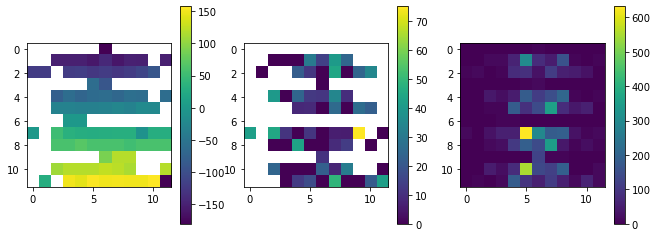

In [135]:
fig,ax = plt.subplots(1,3)
fig.set_size_inches((11,4))
ims = ax[0].imshow(b_mat[:,:,0])
fig.colorbar(ims,ax=ax[0])
ims = ax[1].imshow(np.sqrt(b_mat[:,:,1]))
fig.colorbar(ims,ax=ax[1])
ims = ax[2].imshow(counts)
fig.colorbar(ims,ax=ax[2])

In [134]:
np.sqrt(5000)

70.71067811865476